<a href="https://colab.research.google.com/github/TobyChen320/DS-Unit-2-Kaggle-Challenge/blob/master/Toby_Chen_DSPT6_Kaggle_Competition_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install category_encoders graphviz pandas==0.23.4

In [0]:
# %matplotlib inline
# import category_encoders as ce
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import seaborn as sns
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import RobustScaler
# LOCAL = '../data/tanzania/'
# WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Tree-Ensembles/master/data/tanzania/'
# source = WEB
# train = pd.merge(pd.read_csv(source + 'train_features.csv'), 
#                  pd.read_csv(source + 'train_labels.csv'))
# test = pd.read_csv(source + 'test_features.csv')
# sample_submission = pd.read_csv(source + 'sample_submission.csv')
# # Split train into train & val
# train, val = train_test_split(train, train_size=0.75, test_size=0.25, 
#                               stratify=train['status_group'], random_state=42)
# train.shape, val.shape, test.shape

In [0]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.75, test_size=0.25, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


((44550, 41), (14850, 41), (14358, 40))

In [0]:
train['status_group'].value_counts(normalize=True)

functional                 0.543075
non functional             0.384242
functional needs repair    0.072682
Name: status_group, dtype: float64

In [0]:
val['status_group'].value_counts(normalize=True)

functional                 0.543098
non functional             0.384242
functional needs repair    0.072660
Name: status_group, dtype: float64

In [0]:
import pandas_profiling
pandas_profiling.__version__
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [0]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    X = X.copy()

    X['latitude']=X['latitude'].replace(-2e-08, 0)

    cols_with_zeros=['longitude', 'latitude', 'construction_year', 'num_private', 'amount_tsh', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].fillna(X[col].mean())

    X = X.drop(columns=['quantity_group', 'payment_type'])

    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    X['year_recorded'] = X['date_recorded'].dt.year

    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
    return X

train=wrangle(train)
val=wrangle(val)
test=wrangle(test)

In [0]:
# Target
target='status_group'
# Training features
train_features=train.drop(columns=[target, 'id'])
# Numeric features
numeric_features=train_features.select_dtypes(include='number').columns.tolist()
# High cardinality
cardinality=train_features.select_dtypes(exclude='number').nunique()
# Categories
categorical_features=cardinality[cardinality<=50].index.tolist()
# Final features
features=numeric_features+categorical_features

In [0]:
X_train=train[features]
y_train=train[target]
X_val=val[features]
y_val=val[target]
X_test=test[features]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((44550, 30), (44550,), (14850, 30), (14850,), (14358, 30))

In [0]:
# Fit transform on train. Transform on val, and test.
encoder=ce.OneHotEncoder(use_cat_names=True)
X_train_encoded=encoder.fit_transform(X_train)
X_val_encoded=encoder.transform(X_val)
X_test_encoded=encoder.transform(X_test)

# Scaling fit transform on train. Transform on val and test.
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train_encoded)
X_val_scaled=scaler.transform(X_val_encoded)
X_test_scaled=scaler.transform(X_test_encoded)

# Fitting model.
model=LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))
y_pred=model.predict(X_test_scaled)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-01.csv', index=False)

Validation Accuracy 0.7369696969696969


In [0]:
from sklearn.tree import DecisionTreeClassifier
model2=DecisionTreeClassifier(random_state=42)
model2.fit(X_train_scaled, y_train)
print('Validation Accuracy', model2.score(X_val_scaled, y_val))
y_pred=model2.predict(X_test_scaled)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-02.csv', index=False)

Validation Accuracy 0.7567676767676768


In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
pipeline=make_pipeline(ce.OneHotEncoder(use_cat_names=True), SimpleImputer(), StandardScaler(), LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1))
pipeline.fit(X_train, y_train)
print(f'Train accuracy: {pipeline.score(X_train, y_train)}')
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')

Train accuracy: 0.7396184062850729
Validation accuracy: 0.7369696969696969


In [0]:
pipeline=make_pipeline(ce.OneHotEncoder(use_cat_names=True), SimpleImputer(), StandardScaler(), DecisionTreeClassifier(random_state=42))
pipeline.fit(X_train, y_train)
print(f'Train accuracy: {pipeline.score(X_train, y_train)}')
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')

Train accuracy: 0.9959820426487093
Validation accuracy: 0.7567676767676768


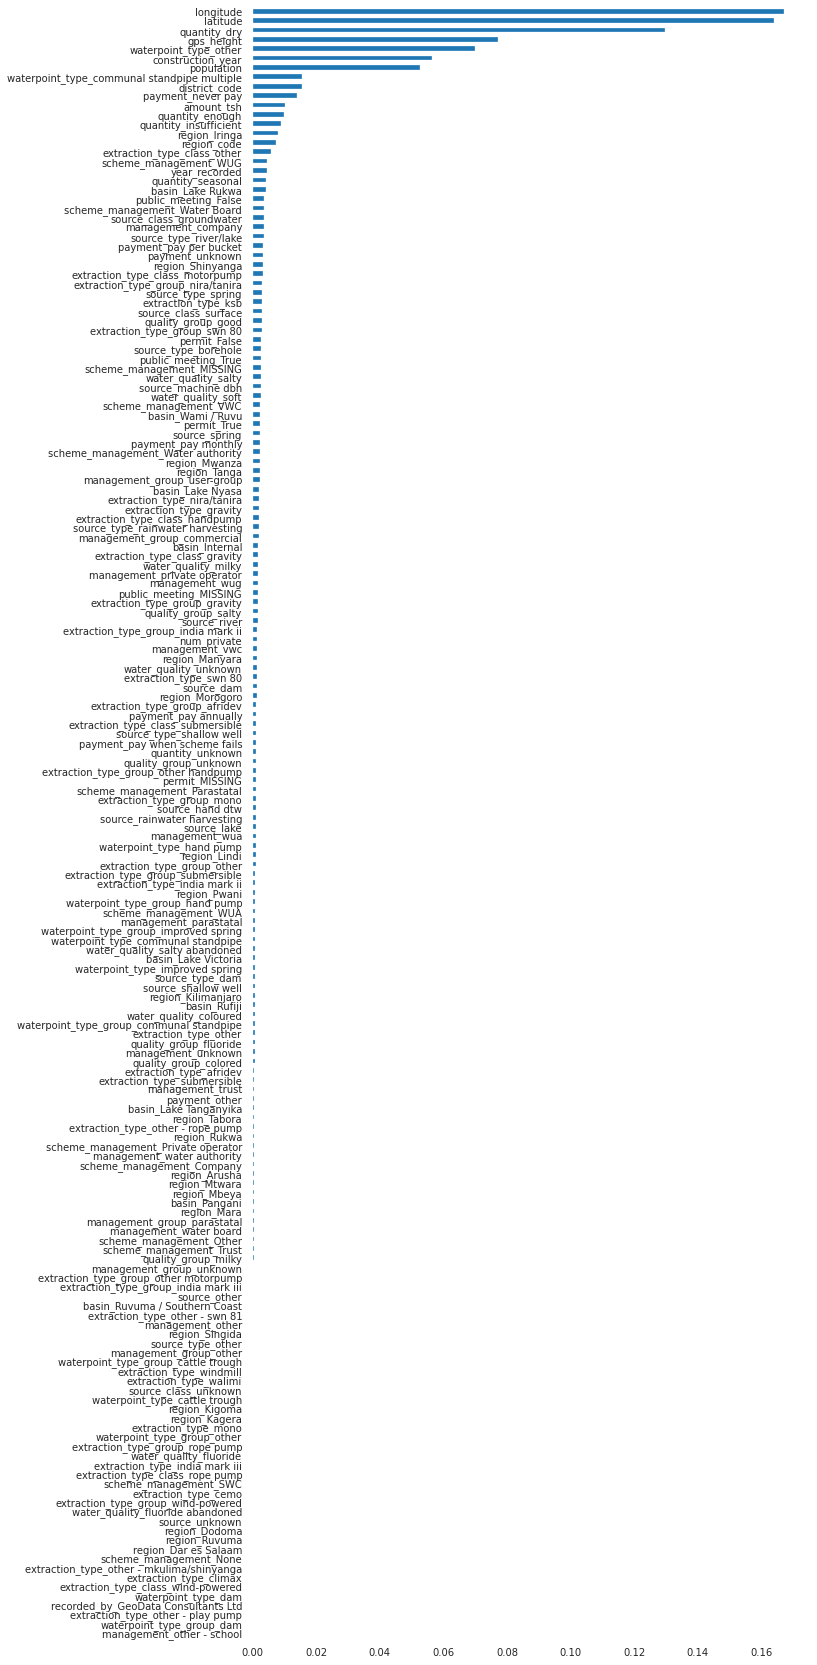

In [0]:
import matplotlib.pyplot as plt
model=pipeline.named_steps['decisiontreeclassifier']
encoder=pipeline.named_steps['onehotencoder']
encoded_columns=encoder.transform(X_val).columns
importances=pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10, 30))
importances.sort_values().plot.barh()